In [1]:
import sys
import numpy as np 
import multiprocessing
import random
from time import time as wall_time
import os
import brian2 as b2
sys.path.append('C:/Users/Nishant Joshi/Documents/Siamese_net/Brian2_GLIF_AllenSDK')
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import * 
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.optimize import leastsq
sys.path.append('C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src')
import numba
from Filter_Rect_LogSpaced import *
from Filter_Rect_LinSpaced import *
from Filter_Exps import *
from scipy.signal import find_peaks
import Tools


INFO       Cache size for target 'cython': 7361 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\Nishant Joshi\.cython\brian_extensions' directory. [brian2]


In [439]:
data = loadmatInPy("G:/My Drive/Analyzed/NC_170728_aCSF_DopD2D1_E2_analyzed.mat")

I_data = data[0]['input_current']
V_data = data[0]['membrane_potential']
spikes_data = data[0]['spikeindices']

In [443]:
data[0]['input_generation_settings']['condition']

'aCSF'

In [3]:
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I']*1e-3
V_data = data['V']
spikes_data = data['spikes']    

In [4]:
# with open("G:/My Drive/Bernstein/170815_NC_109_EXC.pickle",'rb') as f:
#     data = pickle.load(f)
# I_data = data['I']*1e-3
# V_data = data['V']
# spikes_data = data['spikes']    


In [5]:
from neo import io

file_path ='C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/data/gif_test/'
file_name_I ='Cell3_Ger1Training_ch3_1008.ibw'
file_name_V ='Cell3_Ger1Training_ch2_1008.ibw'

test_file_I = os.path.join(file_path, file_name_I)
test_file_V = os.path.join(file_path, file_name_V)
test_igor_read_I = io.IgorIO(test_file_I).read_analogsignal()
test_igor_read_V = io.IgorIO(test_file_V).read_analogsignal()

In [6]:
# t_data = test_igor_read_I.times
# I_data = np.hstack(test_igor_read_I.as_array())
# V_data = np.hstack(test_igor_read_V.as_array())

In [7]:
# spike_threshold = -0.001
# current_spike_mask, _ = find_peaks(V_data,
#                                     height=spike_threshold)
# t_start = 55
# t_stop = 100
# current_spike_mask_t  = current_spike_mask[np.where((current_spike_mask>=10000*t_start)&(current_spike_mask<=10000*t_stop))]
# plt.plot(t_data[int(t_start*10000):int(t_stop*10000)],V_data[int(t_start*10000):int(t_stop*10000)])

# plt.plot(t_data[current_spike_mask_t], V_data[current_spike_mask_t], '.', ms=10)

In [8]:
print(len(spikes_data)/360)

3.6194444444444445


In [119]:
class EphysData:

    def __init__(self,I,V,spikes,dt,start,stop):
        self.I = I[int(start/dt):int(stop/dt)]
        self.V = V[int(start/dt):int(stop/dt)]
        self.spikes = spikes[(spikes>=int(start/dt))&(spikes<=int(stop/dt))]
        self.spikes = self.spikes
        self.dt = dt
        self.spiketimes = self.spikes*dt 
        self.T = stop-start #(ms)
    def getSpikeTimes(self):
        return self.spiketimes
    def getBinarySpikeTrain(self):
        b_spikes = np.zeros(len(self.V))
        b_spikes[self.spikes] =1
        return b_spikes

class Parameter:

    def __init__(self):
        None
    
    def getSpikeTimes(self):
        return None

experiment = EphysData(I_data,V_data,spikes_data,1/20,0,100*1000)
experiment_test = EphysData(I_data,V_data,spikes_data,1/20,0*1000,200*1000)
parameter_glif = Parameter


# experiment = EphysData(I_data/1e-9,V_data*1000,spikes_data,1/10,0,100*1000)
# experiment_test = EphysData(I_data,V_data*1000,spikes_data,1/10,0*1000,200*1000)
# parameter_glif = Parameter


Estimate voltage reset (Tref = 4.0 ms)...


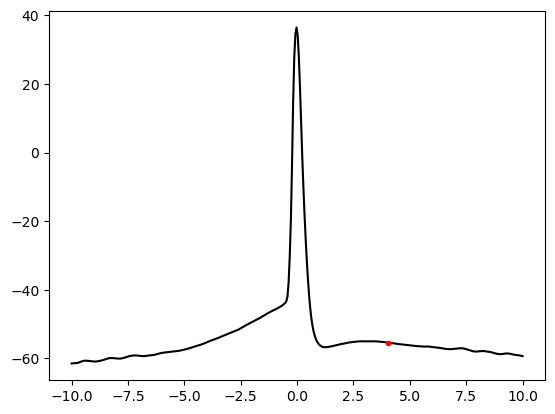

Done! Vr = -55.35 mV (computed on 365 spikes)


In [120]:
def get_average_spike_shape(spikes,V,t_before=10,t_after=10,dt=1/20):
    spike_shapes = []
    t_before_idx = int((1/dt)*t_before)
    t_after_idx = int((1/dt)*t_after)

    for i in spikes:
        
        if len(V[i-t_before_idx:i+t_after_idx])==(t_before_idx+t_after_idx):
            spike_shapes.append(V[i-t_before_idx:i+t_after_idx])
        else:
           print(len(V[i:]))
    return np.mean(spike_shapes,axis=0),np.linspace(-t_before,t_after,int((t_before+t_after)/dt))

def fitVoltageReset(experiment,parameters, Tref,dt=1/20, do_plot=False):
    
    """
    Implement Step 1 of the fitting procedure introduced in Pozzorini et al. PLOS Comb. Biol. 2015
    experiment: Experiment object on which the model is fitted.
    Tref: ms, absolute refractory period. 
    The voltage reset is estimated by computing the spike-triggered average of the voltage.
    """
    
    print("Estimate voltage reset (Tref = %0.1f ms)..." % (Tref))
    
    # Fix absolute refractory period
    dt = experiment.dt
    Tref = Tref
    t_before = 10 
    t_after = 10
    all_spike_nb = len(experiment.spikes)
    spike_average,support = get_average_spike_shape(experiment.spikes,experiment.V,t_before=t_before,t_after=t_after,dt=dt)
    # Estimate voltage reset
    Tref_ind = np.where(support >= int(Tref))[0][0]
    Vr = spike_average[Tref_ind]
    parameters.Vr = Vr
    # Save average spike shape
    avg_spike_shape = spike_average
    avg_spike_shape_support = support
    
    if do_plot :
        plt.figure()
        plt.plot(support, spike_average, 'black')
        plt.plot([support[Tref_ind]], [Vr], '.', color='red')            
        plt.show()
    
    print("Done! Vr = %0.2f mV (computed on %d spikes)" % (Vr, all_spike_nb))
    
fitVoltageReset(experiment=experiment,parameters=parameter_glif,Tref=4,do_plot=True)

In [121]:
from numba import jit

def simulateDeterministic_forceSpikes(experiment, parameters, eta, I, V0, spks):
    """
    Simulate the subthreshold response of the GIF model to an input current I (nA) with time step dt.
    Adaptation currents are forced to occur at times specified in the list spks (in ms) given as an argument
    to the function. V0 indicates the initial condition V(t=0)=V0.
    
    The function returns:
    
    - time     : ms, support for V, eta_sum, V_T, spks
    - V        : mV, membrane potential
    - eta_sum  : nA, adaptation current
    """
    # Input parameters
    p_T = len(I)
    p_dt = experiment.dt
      
    # Model parameters
    p_gl = parameters.gl
    p_C = parameters.C 
    p_El = parameters.El
    p_Vr = parameters.Vr
    p_Tref = parameters.Tref
    p_Tref_i = int(parameters.Tref / parameters.dt)
    
    # Model kernel      
    (p_eta_support, p_eta) = eta.getInterpolatedFilter(experiment.dt)   
    p_eta = p_eta.astype('double')
    p_eta_l = len(p_eta)
    


    # Define arrays

    I = np.array(I, dtype=np.double)
    spks = np.array(spks, dtype=np.double)                      
    spks_i = np.array(Tools.timeToIndex(spks, experiment.dt), dtype=np.int32)
    
    # Compute adaptation current (sum of eta triggered at spike times in spks) 
    eta_sum = np.zeros(int(p_T + 1.1 * p_eta_l + p_Tref_i), dtype=np.double)   
    
    for s in spks_i:
        eta_sum[s + 1 + p_Tref_i: s + 1 + p_Tref_i + p_eta_l] += p_eta
    
    eta_sum = eta_sum[:p_T]  

    @numba.jit(nopython=True)
    def runforV(V0,p_T,p_dt,p_C,p_gl,p_El,p_Vr,I,eta_sum):

        # Set initial condition
        V = np.zeros(p_T, dtype=np.double)
        V[0] = V0

        # Simulate the model
        for t in range(p_T - 1):
            # Integrate voltage
            V[t+1] = V[t] + p_dt / p_C * (-p_gl * (V[t] - p_El) + I[t] - eta_sum[t])

            # Check for forced spikes
            if t in spks_i:
                V[t-1] = 0
                V[t] = p_Vr
        return V
    V = runforV(V0,p_T,p_dt,p_C,p_gl,p_El,p_Vr,I,eta_sum)
    # Compute time array
    time = np.arange(p_T) * experiment.dt

    # Trim eta_sum to match time array length
    eta_sum = eta_sum[:p_T]

    return time, V, eta_sum


In [122]:
eta     = Filter_Rect_LogSpaced()    # nA, spike-triggered current (must be instance of class Filter)
gamma   = Filter_Rect_LogSpaced()    # mV, spike-triggered movement of the firing threshold (must be instance of class Filter)

eta.setMetaParameters(length=500.0, binsize_lb=2.0, binsize_ub=1000.0, slope=4.5)
gamma.setMetaParameters(length=500.0, binsize_lb=5.0, binsize_ub=1000.0, slope=5.0)

# Initialize the spike-triggered current eta with an exponential function        

def expfunction_eta(x):
    return 0.2*np.exp(-x/100.0)

def expfunction_gamma(x):
    return 10.0*np.exp(-x/100.0)
        
gamma.setFilter_Function(expfunction_gamma)        
        
eta.setFilter_Function(expfunction_eta)

# eta = Filter_Exps()
# eta.setFilter_Timescales([0.1,0.5, 1.0, 5.0, 30.0, 70.0, 100.0,200, 500.0])
 
# gamma = Filter_Exps()
# gamma.setFilter_Timescales([5.0, 30.0, 70.0, 100.0,200, 500.0])


In [123]:
experiment.Tref = 4
parameter_glif.Tref = experiment.Tref
parameter_glif.dt = experiment.dt

In [124]:
def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes

def fitSubthresholdDynamics(experiment,eta, parameters, DT_beforeSpike=5.0):
        
    """
    Implement Step 2 of the fitting procedure introduced in Pozzorini et al. PLOS Comb. Biol. 2015
    The voltage reset is estimated by computing the spike-triggered average of the voltage.
    experiment: Experiment object on which the model is fitted.
    DT_beforeSpike: in ms, data right before spikes are excluded from the fit. This parameter can be used to define that time interval.
    """  
                
    print("\nGIF MODEL - Fit subthreshold dynamics..." )
        
    # Expand eta in basis functions
    dt = experiment.dt
    
    
    # Build X matrix and Y vector to perform linear regression (use all traces in training set)    
    # For each training set an X matrix and a Y vector is built.   
    ####################################################################################################
    X = []
    Y = []
    tr = experiment
            
    # Compute the the X matrix and Y=\dot_V_data vector used to perform the multilinear linear regression (see Eq. 17.18 in Pozzorini et al. PLOS Comp. Biol. 2015)
    (X_tmp, Y_tmp) = fitSubthresholdDynamics_Build_Xmatrix_Yvector(tr, experiment.Tref,DT_beforeSpike=DT_beforeSpike)


    # Concatenate matrixes associated with different traces to perform a single multilinear regression
    ####################################################################################################

    X = X_tmp
    Y = Y_tmp

    # Perform linear Regression defined in Eq. 17 of Pozzorini et al. PLOS Comp. Biol. 2015
    ####################################################################################################
    
    print("\nPerform linear regression...")
    XTX     = np.dot(np.transpose(X), X)
    XTX_inv = np.linalg.inv(XTX)
    XTY     = np.dot(np.transpose(X), Y)
    b       = np.dot(XTX_inv, XTY)
    b       = b.flatten()


    # Extract explicit model parameters from regression result b
    ####################################################################################################

    C  = 1./b[1]
    gl = -b[0]*C
    El = b[2]*C/gl
    parameters.gl = gl
    parameters.C = C
    parameters.El = El

    eta.setFilter_Coefficients(-b[3:]*C)

    # self.printParameters()   
    
    
    # Compute percentage of variance explained on dV/dt
    ####################################################################################################

    var_explained_dV = 1.0 - np.mean((Y - np.dot(X,b))**2)/np.var(Y)
    print("Percentage of variance explained (on dV/dt): %0.2f" % (var_explained_dV*100.0))

    
    # Compute percentage of variance explained on V (see Eq. 26 in Pozzorini et al. PLOS Comp. Biol. 2105)
    ####################################################################################################

    SSE = 0     # sum of squared errors
    VAR = 0     # variance of data
    
    # for tr in experiment.trainingset_traces :
    
    #     if tr.useTrace :

    # Simulate subthreshold dynamics 
    (time, V_est, eta_sum_est) = simulateDeterministic_forceSpikes(experiment, parameters, eta, tr.I, tr.V[0], tr.getSpikeTimes())
    
    indices_tmp = getROI_FarFromSpikes(experiment, 0.0, experiment.Tref)
    
    SSE += sum((V_est[indices_tmp] - tr.V[indices_tmp])**2)
    print('MSE ',np.mean(SSE))
    VAR += len(indices_tmp)*np.var(tr.V[indices_tmp])
            
    var_explained_V = 1.0 - SSE / VAR
    
    print("Percentage of variance explained (on V): %0.2f" % (var_explained_V*100.0))

def getROI_FarFromSpikes(experiment, DT_before, DT_after):

        """
        Return indices of the trace which are in ROI. Exclude all datapoints which are close to a spike.
        DT_before: ms
        DT_after: ms
        These two parameters define the region to cut around each spike.
        """
        
        L = len(experiment.V)
        
        LR_flag = np.ones(L)    
        
        
        # Select region in ROI
        ROI_ind = np.arange(len(experiment.V))
        LR_flag[ROI_ind] = 0.0

        # Remove region around spikes
        DT_before_i = int(DT_before/experiment.dt)
        DT_after_i  = int(DT_after/experiment.dt)
        
        
        for s in experiment.spikes :
            
            lb = max(0, s - DT_before_i)
            ub = min(L, s + DT_after_i)
            
            LR_flag[ lb : ub] = 1
            
        
        indices = np.where(LR_flag==0)[0]  

        return indices

def fitSubthresholdDynamics_Build_Xmatrix_Yvector(experiment, Tref, DT_beforeSpike=5.0):
    """
    Compute the X matrix and the Y vector (i.e. \dot_V_data) used to perfomr the linear regression 
    defined in Eq. 17-18 of Pozzorini et al. 2015 for an individual experimental trace provided as parameter.
    The input parameter trace is an ojbect of class Trace.
    """
            
    # Length of the voltage trace       
    Tref_ind = int(Tref/experiment.dt)
    
    
    # Select region where to perform linear regression (specified in the ROI of individual taces)
    ####################################################################################################
    selection = getROI_FarFromSpikes(experiment, DT_beforeSpike, Tref)
    selection_l = len(selection)
    
    
    # Build X matrix for linear regression (see Eq. 18 in Pozzorini et al. PLOS Comp. Biol. 2015)
    ####################################################################################################
    X = np.zeros( (selection_l, 3) )
    
    # Fill first two columns of X matrix        
    X[:,0] = experiment.V[selection]
    X[:,1] = experiment.I[selection]
    X[:,2] = np.ones(selection_l) 
    
    
    # Compute and fill the remaining columns associated with the spike-triggered current eta               
    X_eta = eta.convolution_Spiketrain_basisfunctions(experiment.getSpikeTimes() + Tref, experiment.T, experiment.dt) 
    X = np.concatenate( (X, X_eta[selection,:]), axis=1 )


    # Build Y vector (voltage derivative \dot_V_data)    
    ####################################################################################################
    Y = np.array( np.concatenate( (np.diff(experiment.V)/experiment.dt, [0]) ) )[selection]      

    return (X, Y)

fitSubthresholdDynamics(experiment,eta,parameter_glif)

WARNING    <>:135: SyntaxWarning: invalid escape sequence '\d'
 [py.warnings]
WARNING    <>:135: SyntaxWarning: invalid escape sequence '\d'
 [py.warnings]
WARNING    C:\Users\Nishant Joshi\AppData\Local\Temp\ipykernel_27604\1914083479.py:135: SyntaxWarning: invalid escape sequence '\d'
  """
 [py.warnings]



GIF MODEL - Fit subthreshold dynamics...
(2000000, 18)

Perform linear regression...
Percentage of variance explained (on dV/dt): 18.48
MSE  19994352.60419402
Percentage of variance explained (on V): 90.78


In [125]:
     
def plotParameters(parameters,eta,gamma):

    """
    Generate figure with model filters.
    """

    # plt.figure(facecolor='white', figsize=(14,4))
        
    # # Plot kappa
    # plt.subplot(1,3,1)

    fig, [ax1,ax2,ax3] = plt.subplots(1,3,facecolor='white', figsize=(14,4))

    K_support = np.linspace(0,150.0, 300)             
    K = 1./parameters.C*np.exp(-K_support/(parameters.C/parameters.gl)) 


    ax1.plot(K_support, K, color='red', lw=2)
    ax1.plot([K_support[0], K_support[-1]], [0,0], ls=':', color='black', lw=2)
        
    ax1.set_xlim([K_support[0], K_support[-1]])    
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Membrane filter (MOhm/ms)")        

    # Plot eta
    # plt.subplot(1,3,2)

    (eta_support, eta) = eta.getInterpolatedFilter(parameters.dt) 

    ax2.plot(eta_support, eta, color='red', lw=2)
    # plt.plot([eta_support[0], eta_support[-1]], [0,0], ls=':', color='black', lw=2)

    ax2.set_xlim([eta_support[0], eta_support[-1]])    
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Eta (nA)")

    # Plot gamma
    # plt.subplot(1,3,3)

    (gamma_support, gamma) = gamma.getInterpolatedFilter(parameters.dt)

    ax3.plot(gamma_support, gamma, color='red', lw=2)
    # plt.plot([gamma_support[0], gamma_support[-1]], [0,0], ls=':', color='black', lw=2)

    ax3.set_xlim([gamma_support[0], gamma_support[-1]])    
    ax3.set_xlabel("Time (ms)")
    ax3.set_ylabel("Gamma (mV)")
    plt.subplots_adjust(left=0.05, bottom=0.15, right=0.95, top=0.92, wspace=0.35, hspace=0.25)
    plt.show()

def printParameters(parameters):

    """
    Print model parameters on terminal.
    """
    try:
        print("\n-------------------------")        
        print("GIF model parameters:")
        print("-------------------------")
        print("tau_m (ms):\t%0.3f"  % (parameters.C/parameters.gl))
        print("R (MOhm):\t%0.3f"    % (1.0/parameters.gl))
        print("C (nF):\t\t%0.3f"    % (parameters.C))
        print("gl (nS):\t%0.6f"     % (parameters.gl))
        print("El (mV):\t%0.3f"     % (parameters.El))
        print("Tref (ms):\t%0.3f"   % (parameters.Tref))
        print("Vr (mV):\t%0.3f"     % (parameters.Vr))     
        print("Vt* (mV):\t%0.3f"    % (parameters.Vt_star))    
        print("DV (mV):\t%0.3f"     % (parameters.DV)) 
        print("dt (ms):\t%0.3f"     % (parameters.dt)) 

        print("-------------------------\n")
    except:
        print("\n-------------------------")        
        print("GIF model parameters:")
        print("-------------------------")
        print("tau_m (ms):\t%0.3f"  % (parameters.C/parameters.gl))
        print("R (MOhm):\t%0.3f"    % (1.0/parameters.gl))
        print("C (nF):\t\t%0.3f"    % (parameters.C))
        print("gl (nS):\t%0.6f"     % (parameters.gl))
        print("El (mV):\t%0.3f"     % (parameters.El))
        print("Tref (ms):\t%0.3f"   % (parameters.Tref))
        print("Vr (mV):\t%0.3f"     % (parameters.Vr))     
        # print("Vt* (mV):\t%0.3f"    % (parameters.Vt_star))    
        # print("DV (mV):\t%0.3f"     % (parameters.DV)) 
        print("dt (ms):\t%0.3f"     % (parameters.dt)) 

        print("-------------------------\n")

printParameters(parameter_glif)             


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.414
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.249
Tref (ms):	4.000
Vr (mV):	-55.354

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.414
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.249
Tref (ms):	4.000
Vr (mV):	-55.354
dt (ms):	0.050
-------------------------



In [126]:
       
def fitStaticThreshold(experiment,parameters,eta):
    
    """
    Implement Step 3 of the fitting procedure introduced in Pozzorini et al. PLOS Comb. Biol. 2015
    Instead of directly fitting a dynamic threshold, this function just fit a constant threshold.
    The output of this fit can be used as a smart initial condition to fit the full GIF model (i.e.,
    a model featuting a spike-triggered current gamma). See Pozzorini et al. PLOS Comp. Biol. 2015
    experiment: Experiment object on which the model is fitted.
    """

    print("GIF MODEL - Fit static threshold...")

    
    

        
    # Define initial conditions (based on the average firing rate in the training set)
    ###############################################################################################
    
    nbSpikes = len(experiment.spikes) 
    duration = experiment.T 
    
    mean_firingrate = 1000.0*nbSpikes/duration      
    print('mean firing rate ',mean_firingrate)
    lambda0 = 1.0
    DV = 50.0
    Vt_star = -np.log(mean_firingrate)*DV


    # Perform maximum likelihood fit (Newton method)    
    ###############################################################################################

    beta0_staticThreshold = [1/DV, -Vt_star/DV] 
    beta_opt = maximizeLikelihood(experiment,parameters,eta, beta0_staticThreshold, buildXmatrix_staticThreshold) 
        
        
    # Store result of constnat threshold fitting  
    ###############################################################################################
    
    DV      = 1.0/beta_opt[0]
    Vt_star = -beta_opt[1]*DV 
    gamma.setFilter_toZero()
    
    parameters.DV = DV
    parameters.Vt_star = Vt_star

    printParameters(parameters)

def fitThresholdDynamics(experiment,parameters,gamma):
                
    """
    Implement Step 3 of the fitting procedure introduced in Pozzorini et al. PLOS Comb. Biol. 2015
    Fit firing threshold dynamics by solving Eq. 20 using Newton method.
    
    experiment: Experiment object on which the model is fitted.
    """        
    
    print("GIF MODEL - Fit dynamic threshold...")
    
    

    # Perform maximum likelihood fit (Newton method) 
    ###############################################################################################
    # Define initial conditions
    beta0_dynamicThreshold = np.concatenate( ( [1/parameters.DV], [-parameters.Vt_star/parameters.DV], gamma.getCoefficients()/parameters.DV))

    beta_opt = maximizeLikelihood(experiment,parameters,gamma, beta0_dynamicThreshold, buildXmatrix_dynamicThreshold)

    
    # Store result
    ###############################################################################################
    
    DV      = 1.0/beta_opt[0]
    Vt_star = -beta_opt[1]*DV 
    gamma.setFilter_Coefficients(-beta_opt[2:]*DV)

    parameters.DV = DV
    parameters.Vt_star = Vt_star

    # printParameters(parameters)        
    
def maximizeLikelihood(experiment,parameters,filter , beta0, buildXmatrix, maxIter=10**3, stopCond=10**-6) :

    ###
    ### THIS IMPLEMENTATION IS NOT SO COOL :(
    ### IN NEW VERSION OF THE CODE I SHOULD IMPLEMENT A NEW CLASS THAT TAKES CARE OF MAXLIKELIHOOD ON lambda=exp(Xbeta) model
    ###
    
    """
    Maximize likelihood. This function can be used to fit any model of the form lambda=exp(Xbeta).
    This function is used to fit both:
    - static threshold
    - dynamic threshold
    The difference between the two functions is in the size of beta0 and the returned beta, as well
    as the function buildXmatrix.
    """
    
    # Precompute all the matrices used in the gradient ascent (see Eq. 20 in Pozzorini et al. 2015)
    ################################################################################################
    
    # here X refer to the matrix made of y vectors defined in Eq. 21 (Pozzorini et al. 2015)
    # since the fit can be perfomed on multiple traces, we need lists
    all_X        = []           
    
    # similar to X but only contains temporal samples where experimental spikes have been observed 
    # storing this matrix is useful to improve speed when computing the likelihood as well as its derivative
    all_X_spikes = []
    
    # sum X_spikes over spikes. Precomputing this quantity improve speed when the gradient is evaluated
    all_sum_X_spikes = []
    
    
    # variables used to compute the loglikelihood of a Poisson process spiking at the experimental firing rate
    T_tot = 0.0
    N_spikes_tot = 0.0
    
    traces_nb = 1
    
    # for tr in experiment.trainingset_traces:
        
    #     if tr.useTrace :              
            
    #         traces_nb += 1
            
    # Simulate subthreshold dynamics 
    (time, V_est, eta_sum_est) = simulateDeterministic_forceSpikes(experiment, parameters, filter ,experiment.I, experiment.V[0], experiment.getSpikeTimes())
                    
    # Precomputes matrices to compute gradient ascent on log-likelihood
    # depeinding on the model being fitted (static vs dynamic threshodl) different buildXmatrix functions can be used
    (X_tmp, X_spikes_tmp, sum_X_spikes_tmp, N_spikes, T) = buildXmatrix(experiment, V_est,filter) 
        
    T_tot        += T
    N_spikes_tot += N_spikes
        
    all_X.append(X_tmp)
    all_X_spikes.append(X_spikes_tmp)
    all_sum_X_spikes.append(sum_X_spikes_tmp)
    
    # Compute log-likelihood of a poisson process (this quantity is used to normalize the model log-likelihood)
    ################################################################################################
    
    logL_poisson = N_spikes_tot*(np.log(N_spikes_tot/T_tot)-1)


    # Perform gradient ascent
    ################################################################################################

    print("Maximize log-likelihood (bit/spks)...")
    lambda0 = 1
    beta = beta0
    # print('beta ',beta)
    old_L = 1

    for i in range(maxIter) :
        
        learning_rate = 1.0
        
        # In the first iterations using a small learning rate makes things somehow more stable
        if i<=10 :                      
            learning_rate = 0.1
        
        
        L=0; G=0; H=0;  
            
        for trace_i in np.arange(traces_nb):
            # compute log-likelihood, gradient and hessian on a specific trace (note that the fit is performed on multiple traces)
            (L_tmp,G_tmp,H_tmp) = computeLikelihoodGradientHessian(experiment,lambda0,beta, all_X[trace_i], all_X_spikes[trace_i], all_sum_X_spikes[trace_i])
            
            # note that since differentiation is linear: gradient of sum = sum of gradient ; hessian of sum = sum of hessian
            L+=L_tmp 
            G+=G_tmp 
            H+=H_tmp
        
        
        # Update optimal parametes (ie, implement Newton step) by tacking into account multiple traces
        
        beta = beta - learning_rate*np.dot(np.linalg.inv(H),G)
            
        if (i>0 and abs((L-old_L)/old_L) < stopCond) :              # If converged
            print("Converged after %d iterations!" % (i+1))
            break
        
        old_L = L
        
        # Compute normalized likelihood (for print)
        # The likelihood is normalized with respect to a poisson process and units are in bit/spks
        L_norm = (L-logL_poisson)/np.log(2)/N_spikes_tot
        print(L_norm)
        
        if np.isnan(L_norm):
            print("Problem during gradient ascent. Optimizatino stopped.")
            break

    if (i==maxIter - 1) :                                           # If too many iterations
        
        print("Not converged after %d iterations." % (maxIter))


    return beta
    
def computeLikelihoodGradientHessian(experiment,lambda0, beta, X, X_spikes, sum_X_spikes) : 
    
    """
    Compute the log-likelihood, its gradient and hessian for a model whose 
    log-likelihood has the same form as the one defined in Eq. 20 (Pozzorini et al. PLOS Comp. Biol. 2015)
    """
    
    # IMPORTANT: in general we assume that the lambda_0 = 1 Hz
    # The parameter lambda0 is redundant with Vt_star, so only one of those has to be fitted.
    # We genearlly fix lambda_0 adn fit Vt_star
            
    dt = experiment.dt/1000.0     # put dt in units of seconds (to be consistent with lambda_0)
    # print('X_spikes shape',np.array(X_spikes).shape,' beta ',np.array(beta).shape)
    X_spikesbeta    = np.dot(X_spikes,beta)
    Xbeta           = np.dot(X,beta)
    expXbeta        = np.exp(Xbeta)

    # Compute loglikelihood defined in Eq. 20 Pozzorini et al. 2015
    L = sum(X_spikesbeta) - lambda0*dt*sum(expXbeta)
                                    
    # Compute its gradient
    G = sum_X_spikes - lambda0*dt*np.dot(np.transpose(X), expXbeta)
    
    # Compute its Hessian
    H = -lambda0*dt*np.dot(np.transpose(X)*expXbeta, X)
    
    return (L,G,H)

def buildXmatrix_staticThreshold(experiment, V_est,filter) :

    """
    Use this function to fit a model in which the firing threshold dynamics is defined as:
    V_T(t) = Vt_star (i.e., no spike-triggered movement of the firing threshold).
    This function computes the matrix X made of vectors y simlar to the ones defined in Eq. 21 (Pozzorini et al. 2015).
    In contrast ot Eq. 21, the X matrix computed here does not include the columns related to the spike-triggered threshold movement.
    """        
    
    # Get indices be removing absolute refractory periods (-self.dt is to not include the time of spike)       
    selection = getROI_FarFromSpikes(experiment,-experiment.dt,-experiment.Tref )
    T_l_selection  = len(selection)

        
    # Get spike indices in coordinates of selection   
    spk_train = experiment.getBinarySpikeTrain()
    spks_i_afterselection = np.where(spk_train[selection]==1)[0]


    # Compute average firing rate used in the fit   
    T_l = T_l_selection*experiment.dt/1000.0                # Total duration of trace used for fit (in s)
    N_spikes = len(spks_i_afterselection)           # Nb of spikes in the trace used for fit

    
    # Define X matrix
    X       = np.zeros((T_l_selection, 2))
    X[:,0]  = V_est[selection]
    X[:,1]  = np.ones(T_l_selection)
    
    # Select time steps in which the neuron has emitted a spike
    X_spikes = X[spks_i_afterselection,:]
        
    # Sum X_spike over spikes    
    sum_X_spikes = np.sum( X_spikes, axis=0)
    
    return (X, X_spikes, sum_X_spikes, N_spikes, T_l)
        
def buildXmatrix_dynamicThreshold( experiment, V_est, filter) :

    """
    Use this function to fit a model in which the firing threshold dynamics is defined as:
    V_T(t) = Vt_star + sum_i gamma(t-hat t_i) (i.e., model with spike-triggered movement of the threshold)
    This function computes the matrix X made of vectors y defined as in Eq. 21 (Pozzorini et al. 2015).
    """
        
    # Get indices be removing absolute refractory periods (-self.dt is to not include the time of spike)       
    selection = getROI_FarFromSpikes(experiment, -experiment.dt, experiment.Tref)
    T_l_selection  = len(selection)

        
    # Get spike indices in coordinates of selection   
    spk_train = experiment.getBinarySpikeTrain()
    spks_i_afterselection = np.where(spk_train[selection]==1)[0]


    # Compute average firing rate used in the fit   
    T_l = T_l_selection*experiment.dt/1000.0                # Total duration of trace used for fit (in s)
    N_spikes = len(spks_i_afterselection)           # Nb of spikes in the trace used for fit
    
    
    # Define X matrix
    X       = np.zeros((T_l_selection, 2))
    X[:,0]  = V_est[selection]
    X[:,1]  = np.ones(T_l_selection)
    
    # Compute and fill the remaining columns associated with the spike-triggered current gamma              
    X_gamma = filter.convolution_Spiketrain_basisfunctions(experiment.getSpikeTimes() + experiment.Tref, experiment.T, experiment.dt)

    X = np.concatenate( (X, X_gamma[selection,:]), axis=1 )

    # Precompute other quantities to speedup fitting
    X_spikes = X[spks_i_afterselection,:]
    sum_X_spikes = np.sum( X_spikes, axis=0)
    return (X, X_spikes, sum_X_spikes,  N_spikes, T_l)



In [437]:
fitStaticThreshold(experiment=experiment,parameters=parameter_glif,eta=eta)
fitThresholdDynamics(experiment,parameter_glif,gamma)

GIF MODEL - Fit static threshold...
mean firing rate  3.65
Maximize log-likelihood (bit/spks)...
-0.5028398717083207
0.9282002358889402
1.096152490909135
1.19537462959227
1.26178140678632
1.3087613791593125
1.3430767786007198
1.3686735600520825
1.3880542442657382
1.4028935342511033
1.4143547990510261
1.423268609236979
1.4563714651057291
1.457044015370125
Converged after 15 iterations!

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.414
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.249
Tref (ms):	4.000
Vr (mV):	-55.354
Vt* (mV):	-79.488
DV (mV):	10.472
dt (ms):	0.050
-------------------------

GIF MODEL - Fit dynamic threshold...
(2000000, 15)
Maximize log-likelihood (bit/spks)...
1.5864708712916136
1.6013819184893174
1.6132209693425954
1.6226879420948024
1.630300383038986
1.6364484286584553
1.6414308331574936
1.6454793657232687
1.6487757847101239
1.6514639211233404
1.6536584523840483
1.6554513842260463
1.6633353461402465
1.6634

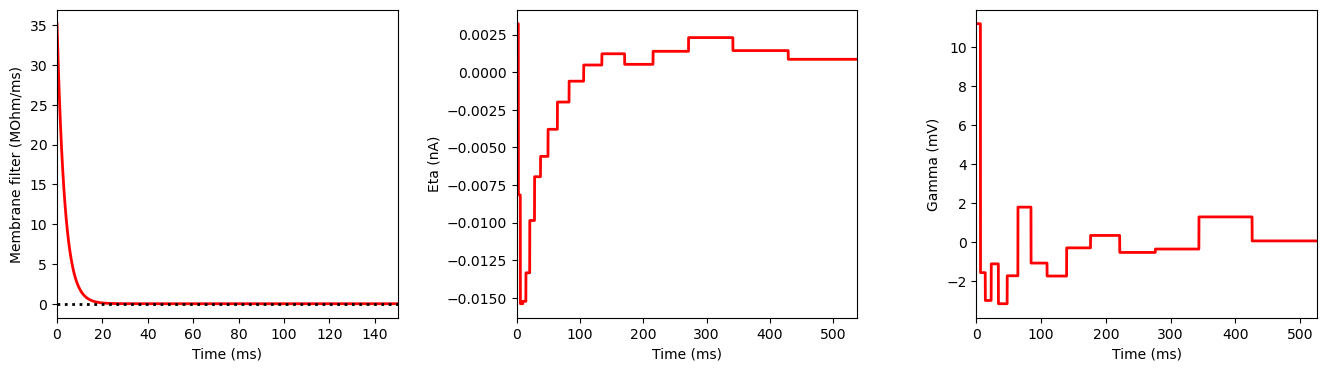

In [128]:
plotParameters(parameter_glif,eta,gamma)

In [438]:
printParameters(parameter_glif)


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.391
R (MOhm):	119.414
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.249
Tref (ms):	4.000
Vr (mV):	-55.354
Vt* (mV):	-79.788
DV (mV):	10.190
dt (ms):	0.050
-------------------------



In [427]:

def get_gamma_factor(model, data, delta, time, dt, rate_correction=True):
    """
    Calculate gamma factor between model and target spike trains,
    with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    """
    model = np.array(model)
    data = np.array(data)

    model = np.array(np.int32(model / dt), dtype=int)
    data = np.array(np.int32(data / dt), dtype=int)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = np.abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = np.sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * data_length * data_rate
    norm = .5*(1 - 2 * data_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*np.abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    # return gamma
    return gamma
    # return np.clip(rate_term - gamma, 0, np.inf)

def simulate(params, I, V0, eta, gamma):
 
        """
        Simulate the spiking response of the GIF model to an input current I (nA) with time step dt.
        V0 indicate the initial condition V(0)=V0.
        The function returns:
        - time     : ms, support for V, eta_sum, V_T, spks
        - V        : mV, membrane potential
        - eta_sum  : nA, adaptation current
        - V_T      : mV, firing threshold
        - spks     : ms, list of spike times 
        """
        np.random.seed(0)
        # Input parameters
        p_T         = len(I)
        p_dt        = params.dt
        
        # Model parameters
        p_gl        = params.gl
        p_C         = params.C
        p_El        = params.El
        p_Vr        = params.Vr
        p_Tref      = params.Tref
        p_Vt_star   = params.Vt_star
        p_DV        = params.DV
        p_lambda0   = params.lambda0
        
        # Model kernels   
        (p_eta_support, p_eta) = eta.getInterpolatedFilter(p_dt)   
        p_eta       = p_eta.astype('double')
        p_eta_l     = len(p_eta)

        (p_gamma_support, p_gamma) = gamma.getInterpolatedFilter(p_dt)   
        p_gamma     = p_gamma.astype('double')
        p_gamma_l   = len(p_gamma)
      
        # Define arrays
        V = np.array(np.zeros(p_T), dtype="double")
        I = np.array(I, dtype="double")
        spks = np.array(np.zeros(p_T), dtype="double")                      
        # eta_sum = np.array(np.zeros(p_T + 2*p_eta_l), dtype="double")
        # gamma_sum = np.array(np.zeros(p_T + 2*p_gamma_l), dtype="double")            
 
        # Set initial condition
        @numba.jit(nopython=True)
        def inner_simulation(I, V0, dt, gl, C, El, Vr, Tref, Vt_star, DV, lambda0, p_eta, p_gamma):
            T_ind = len(I)
            T_ref_ind =int(Tref / (dt))
            eta = p_eta.astype(np.float64)
            gamma = p_gamma.astype(np.float64)
            eta_l = len(eta)
            gamma_l = len(gamma)
            V = np.zeros(T_ind, dtype=np.float64)
            spks = np.zeros(T_ind, dtype=np.float64)

            eta_sum = np.zeros(T_ind + (2 * eta_l), dtype=np.float64)
            gamma_sum = np.zeros(T_ind + (2 * gamma_l), dtype=np.float64)

            p_spikes = []
            V[0] = V0

            # 
            for t in range(T_ind-1):
                V[t+1] = V[t] + dt/C*( -gl*(V[t] - El) + I[t] - eta_sum[t] )
                # COMPUTE PROBABILITY OF EMITTING ACTION POTENTIAL
                lambda_val = lambda0*np.exp((V[t+1]-Vt_star-gamma_sum[t])/DV )
                p_dontspike = np.exp(-lambda_val*(dt/1000.0)) #since lambda0 is in Hz, dt must also be in Hz (this is why dt/1000.0)

                # PRODUCE SPIKE STOCHASTICALLY
                # r = np.random.rand()
                p_spikes.append(p_dontspike)
                r = random.random()
                if r > p_dontspike:
                    if (t+1 < T_ind-1) :               
                        spks[t+1] = 1.0 
                    
                    t = t + T_ref_ind 
                    
                    if (t+1 < T_ind-1):
                        V[t-T_ref_ind] = 60
                        V[t+1] = Vr
                    # // UPDATE ADAPTATION PROCESSES   
                          
                    for j in range(eta_l) : 
                        eta_sum[t+1+j] += eta[j]
                    for j in range(gamma_l) : 
                        gamma_sum[t+1+j] += gamma[j]        
                                
            time = np.arange(T_ind) * dt
            eta_sum = eta_sum[:T_ind]
            V_T = gamma_sum[:T_ind] + Vt_star
            spk_times = np.where(spks == 1.)[0] * dt

            return time, V, eta_sum, V_T, spk_times,p_spikes

        time, V, eta_sum, V_T, spk_times,p_spikes = inner_simulation(I, V0, p_dt, p_gl, p_C, p_El, p_Vr,
                                                            p_Tref, p_Vt_star, p_DV, p_lambda0, p_eta,
                                                            p_gamma)
    
        return (time, V, eta_sum,V_T, spk_times,p_spikes)

def simulate_test(params, I, V0, eta, gamma):
    p_T = len(I)
    p_dt = params.dt
    p_gl = params.gl
    p_C = params.C
    p_El = params.El
    p_Vr = params.Vr
    p_Tref = params.Tref
    p_Vt_star = params.Vt_star
    p_DV = params.DV
    p_lambda0 = params.lambda0

    p_eta_support, p_eta = eta.getInterpolatedFilter(params.dt)
    p_gamma_support, p_gamma = gamma.getInterpolatedFilter(params.dt)
    p_eta = np.float32(p_eta)
    p_eta_l = len(p_eta)
    p_gamma = np.float32(p_gamma)
    p_gamma_l = len(p_gamma)
    p_spike = np.zeros(p_T) 
    V = np.zeros(p_T)
    I = np.array(I)
    spks = np.zeros(p_T)
    eta_sum = np.zeros(p_T + 2 * p_eta_l)
    gamma_sum = np.zeros(p_T + 2 * p_gamma_l)

    V[0] = V0

    @jit(nopython=True)
    def simulate_inner_loop(V, I, spks, eta_sum, gamma_sum, p_T, p_dt, p_gl, p_C, p_El, p_Vr, p_Tref, p_Vt_star, p_DV, p_lambda0, p_eta, p_eta_l, p_gamma, p_gamma_l,p_spike):
        rand_max = np.float64(1.0)  # this is a workaround to avoid numba issues with rand() and rand_max
        p_Tind = len(I)
        p_DV = p_DV
        p_Vt_star = p_Vt_star

        for t in range(p_Tind - 1):
            V[t + 1] = V[t] + p_dt / p_C * (-p_gl * (V[t] - p_El) + I[t] - eta_sum[t])

            lambda_val = p_lambda0 * np.exp((V[t + 1] - p_Vt_star - gamma_sum[t]) / p_DV)
            p_dontspike = np.exp(-lambda_val * (p_dt / 1000.0))
            p_spike[t] = p_dontspike
            r = np.random.rand()
            if r >= p_dontspike:
                if t + 1 < p_Tind - 1:
                    spks[t + 1] = 1.0

                t += int(p_Tref / p_dt)

                if t + 1 < p_Tind - 1:
                    V[t + 1] = p_Vr

                    for j in range(p_eta_l):
                        eta_sum[t + 1 + j] += p_eta[j]

                    for j in range(p_gamma_l):
                        gamma_sum[t + 1 + j] += p_gamma[j]

        return V, spks, eta_sum, gamma_sum , p_spike

    V, spks, eta_sum, gamma_sum,p_spike = simulate_inner_loop(V, I, spks, eta_sum, gamma_sum, p_T, p_dt, p_gl, p_C, p_El, p_Vr, p_Tref, p_Vt_star, p_DV, p_lambda0, p_eta, p_eta_l, p_gamma, p_gamma_l,p_spike)

    time = np.arange(p_T) * params.dt
    eta_sum = eta_sum[:p_T]
    V_T = gamma_sum[:p_T] + p_Vt_star

    spks = (np.where(spks == 1)[0]) * params.dt

    return time, V, eta_sum, V_T, spks,p_spike

def return_spike_response(I,times,parameters,eta,gamma):
    spikes_for_each_trial = []
    for i in range(times):
        time,V, eta_sum, V_T, spks = simulate(params=parameters, I =I,V0=parameters.El,eta=eta,gamma=gamma)
        spikes_for_each_trial.append(spks)
    return spikes_for_each_trial
    

In [419]:
parameter_glif.lambda0 = 1.
time,V, eta_sum, V_T, spks,p_spike = simulate(params=parameter_glif, I =experiment.I, V0=parameter_glif.El,eta=eta,gamma=gamma)
# time_test,V_test, eta_sum_test,gamma_sum_test, V_T_test, spks_test = simulate(params=parameter_glif, I =experiment_test.I,V0=parameter_glif.El,eta=eta,gamma=gamma)
time =time /1000

In [432]:
print('Gamma',get_gamma_factor(spks/1000, experiment.spiketimes/1000 ,5/1000,100,1/20000,rate_correction=False))

Gamma 0.14151690774908823


In [433]:
print('experiment fr: ',len(experiment.spiketimes)/100)
print('model fr: ',len(spks)/100)

experiment fr:  3.65
model fr:  3.49


In [434]:
spks_model = getBinarySpikeTrain(V,spks,experiment.dt,type='nan')
spks_data = getBinarySpikeTrain(experiment.V,experiment.spiketimes,experiment.dt,type='nan')

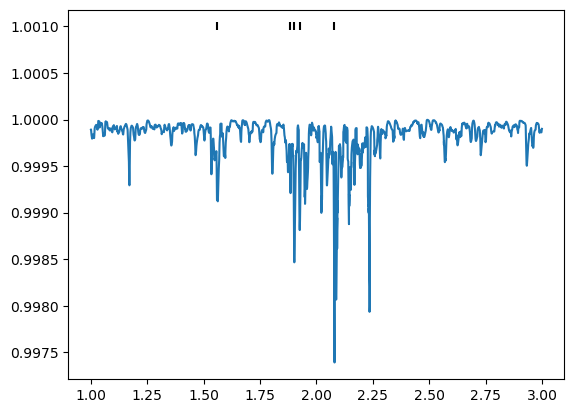

In [435]:
from sklearn.preprocessing import minmax_scale


plot_start_time = 1# s
plot_stop_time = 3 # s

plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],(p_spike[int(plot_start_time*20000):int(plot_stop_time*20000)]))
# plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],minmax_scale(experiment.V[int(plot_start_time*20000):int(plot_stop_time*20000)]))


# plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*1.5,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*1.001,c='black',marker='|')


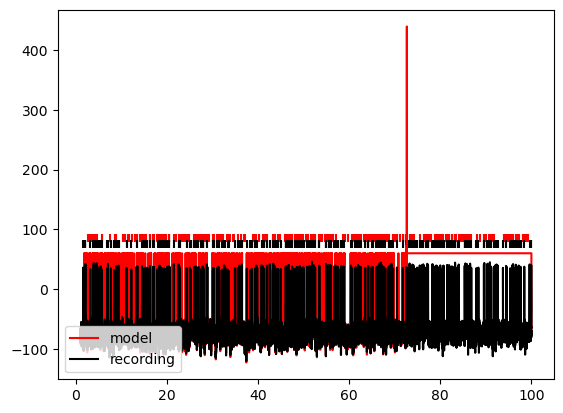

In [418]:
plot_start_time = 1# s
plot_stop_time = 100 # s
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='model')
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],experiment.V[int(plot_start_time*20000):int(plot_stop_time*20000)],c='black',label='recording')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*85,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()

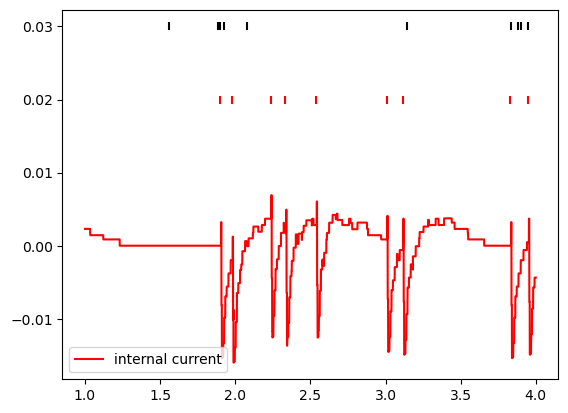

In [260]:
plot_start_time = 1 # s
plot_stop_time = 4
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],eta_sum[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='internal current')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*0.2/10,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*0.3/10,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()

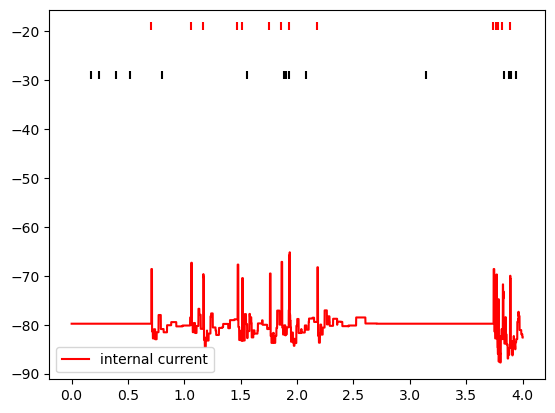

In [152]:
plot_start_time = 0 # s
plot_stop_time = 4
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V_T[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='internal current')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]-20,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]-30,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



In [147]:
eta_sum = eta_sum/np.linalg.norm(eta_sum) 
gamma_sum = V_T/np.linalg.norm(V_T) 


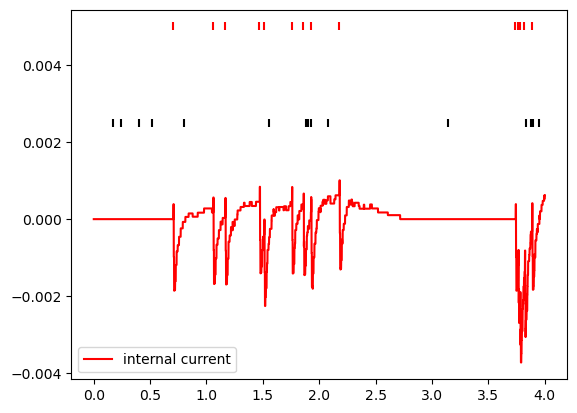

In [157]:
plot_start_time = 0 # s
plot_stop_time = 4
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],eta_sum[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='internal current')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*0.005,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*0.0025,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()


In [139]:
step_I = np.zeros(10*20000)
step_I[5*20000:6*20000] =0.4
# eta.setFilter_toZero()
# gamma.setFilter_toZero()
time,V, eta_sum, V_T, spks = simulate_test(params=parameter_glif, I =step_I, V0=parameter_glif.El,eta=eta,gamma=gamma)


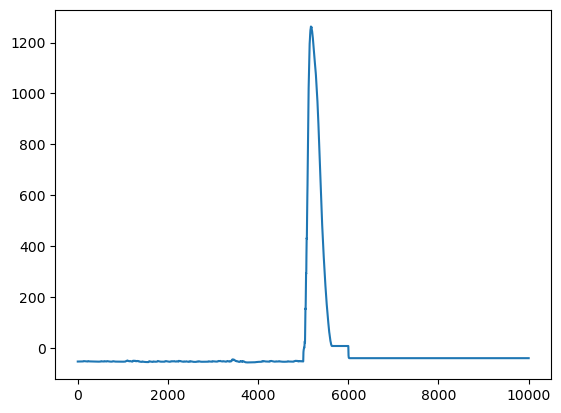

In [140]:
plt.plot(time,V)